# Versions

v1 pairwise

v2 ndcg

v3 map

v4 pairwise,w_rank

# validation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
VER = 4
SVER = 1
IVER = 1
UVER = 1
WVER = 1
FEATURES = [
        'user', 'item_item_count', 'item_user_count', 
        'item_buy_ratio', 'user_user_count', 'user_item_count',
        'user_buy_ratio','w_rank']

In [3]:
!nvidia-smi

Tue Jan 24 11:48:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install -q polars
import polars as pl
import pandas as pd, numpy as np
import pickle, glob, gc
from collections import Counter
import itertools
# multiprocessing 
import psutil
from multiprocessing import Pool
from sklearn.model_selection import GroupKFold
import psutil
N_CORES = psutil.cpu_count()     # Available CPU cores
print(f"N Cores : {N_CORES}")
from multiprocessing import Pool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 78.8 MB/s eta 0:00:00
N Cores : 12


In [5]:
def merge_candidate(SVER,IVER,UVER,WVER,TYPE,MODE):
    candidates = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/suggest/{TYPE}/{MODE}_{TYPE}{SVER}.pqt')
    candidates['session'] = candidates.index
    candidates = candidates.set_index('session')
    item_features = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/item/{MODE}_item{IVER}.pqt')
    candidates = candidates.merge(item_features, left_on='item', right_index=True, how='left').fillna(-1)
    user_features = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/user/{MODE}_user{UVER}.pqt')
    candidates = candidates.merge(user_features, left_on='session', right_index=True, how='left').fillna(-1)
    candidates['user'] = candidates.index
    w2v_features = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/word2vec/{MODE}_{TYPE}{WVER}.pqt')
    w2v_features['session'] = w2v_features.index
    w2v_features['session'] = w2v_features['session'].astype(int)
    w2v_features = w2v_features.drop_duplicates(subset=['item','session'])
    w2v_features['w_rank'] = w2v_features.groupby('session').item.cumcount()+1
    candidates = candidates.merge(w2v_features,on=['session','item'],how='left')
    candidates = candidates.set_index('user')
    return candidates

In [6]:
def merge_target(TYPE,candidates):
    tar = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/otto-validation/test_labels.parquet')
    tar = tar.loc[ tar['type']==TYPE ]
    aids = tar.ground_truth.explode().astype('int32').rename('item')
    tar = tar[['session']].astype('int32').rename({'session':'user'},axis=1)
    tar = tar.merge(aids, left_index=True, right_index=True, how='left')
    tar[TYPE] = 1
    candidates = candidates.merge(tar,on=['user','item'],how='left').fillna(0)
    return candidates

In [7]:
!pip install -q xgboost==1.6.2
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import recall_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 4.6 MB/s eta 0:00:00


In [35]:
candidates = merge_candidate(SVER,IVER,UVER,WVER,'clicks','val')
candidates = merge_target('clicks',candidates)

In [46]:
TARGET = 'clicks'

In [49]:
preds = np.zeros(len(candidates))
skf = GroupKFold(n_splits=5)
for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates[TARGET], groups=candidates['user'] )):

    X_train = candidates.loc[train_idx, FEATURES]
    y_train = candidates.loc[train_idx, TARGET]
    X_valid = candidates.loc[valid_idx, FEATURES]
    y_valid = candidates.loc[valid_idx, TARGET]

    X_train = X_train.sort_values("user").reset_index(drop=True)
    X_valid = X_valid.sort_values("user").reset_index(drop=True)

    train_group = X_train.groupby('user').user.agg('count').values
    valid_group = X_valid.groupby('user').user.agg('count').values

    X_train = X_train.drop(["user"], axis=1)
    X_valid = X_valid.drop(["user"], axis=1)

    dtrain = xgb.DMatrix(X_train, y_train,group=train_group)
    dvalid = xgb.DMatrix(X_valid, y_valid,group=valid_group)

    xgb_parms = {
        'objective':'rank:pairwise', 
        'tree_method':'gpu_hist',
        'random_state': 42, 
        'learning_rate': 0.1,
        "colsample_bytree": 0.8, 
        'max_depth': 6,
    }
    model = xgb.train(xgb_parms, 
        dtrain=dtrain,
        evals=[(dtrain,'train'),(dvalid,'valid')],
        num_boost_round=1000,
        verbose_eval=500)
    preds[valid_idx] = model.predict(dvalid)
    model.save_model(f'XGB_fold{fold}_{TARGET}.xgb')

[0]	train-map:0.55951	valid-map:0.55893
[500]	train-map:0.59572	valid-map:0.59114
[999]	train-map:0.59837	valid-map:0.59115
[0]	train-map:0.56262	valid-map:0.56272
[500]	train-map:0.59543	valid-map:0.59052
[999]	train-map:0.59826	valid-map:0.59089
[0]	train-map:0.55953	valid-map:0.55844
[500]	train-map:0.59547	valid-map:0.58996
[999]	train-map:0.59854	valid-map:0.59022
[0]	train-map:0.55986	valid-map:0.56007
[500]	train-map:0.59529	valid-map:0.59155
[999]	train-map:0.59837	valid-map:0.59196
[0]	train-map:0.55995	valid-map:0.55965
[500]	train-map:0.59549	valid-map:0.59116
[999]	train-map:0.59844	valid-map:0.59132


In [60]:
X_train.head()

,w_rank,item_item_count,item_user_count,item_buy_ratio,user_user_count,user_item_count,user_buy_ratio
0,1.0,33776,19211,0.173970,1,1,0.0
1,21025.0,28341,16057,0.136975,1,1,0.0
2,1226.0,37089,22774,0.165952,1,1,0.0
3,29027.0,15563,8786,0.188653,1,1,0.0
4,22853.0,24588,14741,0.125346,1,1,0.0


In [53]:
predictions = candidates[['user','item']].copy()
predictions['pred'] = preds
predictions = predictions.sort_values(['user','pred'], ascending=[True,False]).reset_index(drop=True)
predictions['n'] = predictions.groupby('user').item.cumcount().astype('int8')

In [50]:
predictions = candidates[['user','item']].copy()
predictions['pred'] = preds
predictions = predictions.sort_values(['user','pred'], ascending=[True,False]).reset_index(drop=True)
predictions['n'] = predictions.groupby('user').item.cumcount().astype('int8')
predictions = predictions.loc[predictions.n<20]
sub = predictions.groupby('user').item.apply(list)
sub = sub.to_frame().reset_index()
sub.item = sub.item.apply(lambda x: " ".join(map(str,x)))
sub.columns = ['session','labels']
sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])
test_labels = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/otto-validation/test_labels.parquet')
test_labels = test_labels.loc[test_labels['type']==TARGET]
test_labels = test_labels.merge(sub, how='left', on=['session'])
test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
print('{} Recall = {:.5f}'.format(TARGET,recall))

clicks Recall = 0.52558


In [54]:
predictions[:50]

,user,item,pred,n
0,11098528,1182614,0.793302,0
1,11098528,884502,0.696514,1
2,11098528,307904,0.671088,2
3,11098528,1157882,0.614358,3
4,11098528,205357,0.590683,4
5,11098528,11830,0.492166,5
6,11098528,876129,0.460396,6
7,11098528,1586171,0.457574,7
8,11098528,1633746,0.452616,8
9,11098528,571762,0.446790,9


In [48]:
X_train.head()

,w_rank,user,item_item_count,item_user_count,item_buy_ratio,user_user_count,user_item_count,user_buy_ratio
20,0.0,11098529,88,59,0.068182,1,1,0.0
21,0.0,11098529,93,62,0.096774,1,1,0.0
22,5306.0,11098529,703,472,0.078236,1,1,0.0
23,385328.0,11098529,61,41,0.032787,1,1,0.0
24,7277.0,11098529,739,562,0.032476,1,1,0.0


In [8]:
def train_xgb(candidates,TARGET):
    preds = np.zeros(len(candidates))
    skf = GroupKFold(n_splits=5)
    for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates[TARGET], groups=candidates['user'] )):

        X_train = candidates.loc[train_idx, FEATURES]
        y_train = candidates.loc[train_idx, TARGET]
        X_valid = candidates.loc[valid_idx, FEATURES]
        y_valid = candidates.loc[valid_idx, TARGET]

        X_train = X_train.sort_values("user").reset_index(drop=True)
        X_valid = X_valid.sort_values("user").reset_index(drop=True)

        train_group = X_train.groupby('user').user.agg('count').values
        valid_group = X_valid.groupby('user').user.agg('count').values

        X_train = X_train.drop(["user"], axis=1)
        X_valid = X_valid.drop(["user"], axis=1)

        dtrain = xgb.DMatrix(X_train, y_train,group=train_group)
        dvalid = xgb.DMatrix(X_valid, y_valid,group=valid_group)

        xgb_parms = {
            'objective':'rank:pairwise', 
            'tree_method':'gpu_hist',
            'random_state': 42, 
            'learning_rate': 0.1,
            "colsample_bytree": 0.8, 
            'max_depth': 6,
        }
        model = xgb.train(xgb_parms, 
            dtrain=dtrain,
            evals=[(dtrain,'train'),(dvalid,'valid')],
            num_boost_round=1000,
            verbose_eval=500)
        preds[valid_idx] = model.predict(dvalid)
        model.save_model(f'XGB_fold{fold}_{TARGET}.xgb')
    predictions = candidates[['user','item']].copy()
    predictions['pred'] = preds
    predictions = predictions.sort_values(['user','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions['n'] = predictions.groupby('user').item.cumcount().astype('int8')
    predictions = predictions.loc[predictions.n<20]
    sub = predictions.groupby('user').item.apply(list)
    sub = sub.to_frame().reset_index()
    sub.item = sub.item.apply(lambda x: " ".join(map(str,x)))
    sub.columns = ['session','labels']
    sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])
    test_labels = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/otto-validation/test_labels.parquet')
    test_labels = test_labels.loc[test_labels['type']==TARGET]
    test_labels = test_labels.merge(sub, how='left', on=['session'])
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    print('{} Recall = {:.5f}'.format(TARGET,recall))

## clicks

In [9]:
%%time
candidates = merge_candidate(SVER,IVER,UVER,WVER,'clicks','val')
candidates = merge_target('clicks',candidates)
train_xgb(candidates,'clicks')
del candidates
_ = gc.collect()

[0]	train-map:0.66752	valid-map:0.66688
[500]	train-map:0.59705	valid-map:0.59252
[999]	train-map:0.60038	valid-map:0.59272
[0]	train-map:0.66649	valid-map:0.66719
[500]	train-map:0.59694	valid-map:0.59185
[999]	train-map:0.60027	valid-map:0.59264
[0]	train-map:0.67060	valid-map:0.66913
[500]	train-map:0.59775	valid-map:0.59209
[999]	train-map:0.60088	valid-map:0.59264
[0]	train-map:0.66588	valid-map:0.66576
[500]	train-map:0.59719	valid-map:0.59298
[999]	train-map:0.60033	valid-map:0.59340
[0]	train-map:0.67090	valid-map:0.67042
[500]	train-map:0.59733	valid-map:0.59279
[999]	train-map:0.60060	valid-map:0.59324
clicks Recall = 0.52558
CPU times: user 11min 49s, sys: 16.1 s, total: 12min 6s
Wall time: 10min 13s


In [61]:
dtrain

## carts

In [10]:
%%time
candidates = merge_candidate(SVER,IVER,UVER,WVER,'carts','val')
candidates = merge_target('carts',candidates)
train_xgb(candidates,'carts')
del candidates
_ = gc.collect()

[0]	train-map:0.92185	valid-map:0.92156
[500]	train-map:0.91654	valid-map:0.91403
[999]	train-map:0.91757	valid-map:0.91399
[0]	train-map:0.92349	valid-map:0.92306
[500]	train-map:0.91640	valid-map:0.91360
[999]	train-map:0.91748	valid-map:0.91365
[0]	train-map:0.92139	valid-map:0.92045
[500]	train-map:0.91659	valid-map:0.91322
[999]	train-map:0.91761	valid-map:0.91325
[0]	train-map:0.92307	valid-map:0.92288
[500]	train-map:0.91652	valid-map:0.91416
[999]	train-map:0.91754	valid-map:0.91422
[0]	train-map:0.92256	valid-map:0.92331
[500]	train-map:0.91640	valid-map:0.91492
[999]	train-map:0.91734	valid-map:0.91494
carts Recall = 0.40965
CPU times: user 10min 7s, sys: 8.13 s, total: 10min 15s
Wall time: 9min 16s


## orders

In [11]:
%%time
candidates = merge_candidate(SVER,IVER,UVER,WVER,'orders','val')
candidates = merge_target('orders',candidates)
train_xgb(candidates,'orders')
del candidates
_ = gc.collect()

[0]	train-map:0.95324	valid-map:0.95336
[500]	train-map:0.94853	valid-map:0.94647
[999]	train-map:0.94955	valid-map:0.94646
[0]	train-map:0.95369	valid-map:0.95261
[500]	train-map:0.94880	valid-map:0.94555
[999]	train-map:0.94983	valid-map:0.94552
[0]	train-map:0.95511	valid-map:0.95455
[500]	train-map:0.94870	valid-map:0.94595
[999]	train-map:0.94972	valid-map:0.94603
[0]	train-map:0.95305	valid-map:0.95293
[500]	train-map:0.94861	valid-map:0.94626
[999]	train-map:0.94961	valid-map:0.94629
[0]	train-map:0.95818	valid-map:0.95884
[500]	train-map:0.94842	valid-map:0.94690
[999]	train-map:0.94945	valid-map:0.94682
orders Recall = 0.64924
CPU times: user 10min 15s, sys: 5.13 s, total: 10min 20s
Wall time: 9min 13s


# inference

In [12]:
def predict(test_candidates,TYPE):
    preds = np.zeros(len(test_candidates))
    test_candidates.reset_index(inplace=True)
    for fold in range(5):
        model = xgb.Booster()
        model.load_model(f'XGB_fold{fold}_{TYPE}.xgb')
        model.set_param({'predictor': 'gpu_predictor'})
        dtest = xgb.DMatrix(data=test_candidates[FEATURES].drop(["user"], axis=1))
        preds += model.predict(dtest)/5
    predictions = test_candidates[['user','item']].copy()
    predictions['pred'] = preds
    predictions = predictions.sort_values(['user','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions['n'] = predictions.groupby('user').item.cumcount().astype('int8')
    predictions = predictions.loc[predictions.n<20]
    sub = predictions.groupby('user').item.apply(list)
    sub = sub.to_frame().reset_index()
    sub.item = sub.item.apply(lambda x: " ".join(map(str,x)))
    sub.columns = ['session_type','labels']
    sub.session_type = sub.session_type.astype('str')+ f'_{TYPE}'
    return sub

## clicks

In [13]:
%%time
test_candidates = merge_candidate(SVER,IVER,UVER,WVER,'clicks','test')
clicks_pred_df = predict(test_candidates,'clicks')
del test_candidates
_ = gc.collect()

CPU times: user 2min 35s, sys: 2.74 s, total: 2min 38s
Wall time: 1min 59s


## carts

In [14]:
%%time
test_candidates = merge_candidate(SVER,IVER,UVER,WVER,'carts','test')
carts_pred_df = predict(test_candidates,'carts')
del test_candidates
_ = gc.collect()

CPU times: user 2min 33s, sys: 2.72 s, total: 2min 36s
Wall time: 1min 57s


## orders

In [15]:
%%time
test_candidates = merge_candidate(SVER,IVER,UVER,WVER,'orders','test')
orders_pred_df = predict(test_candidates,'orders')
del test_candidates
_ = gc.collect()

CPU times: user 2min 28s, sys: 2.69 s, total: 2min 31s
Wall time: 1min 53s


# submission

In [16]:
pred_df = pd.concat([clicks_pred_df, orders_pred_df, carts_pred_df])
pred_df.columns = ["session_type", "labels"]
pred_df.to_csv(f"xgb{VER}.csv", index=False)
pred_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/submission/xgb{VER}.csv', index=False)

In [17]:
!pip install kaggle -q
import os
import json
f = open("/content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [18]:
!kaggle competitions submit -c otto-recommender-system -f xgb4.csv -m ""

100% 780M/780M [00:32<00:00, 24.9MB/s]
Successfully submitted to OTTO – Multi-Objective Recommender System

In [55]:
import matplotlib.pyplot as plt
model = xgb.Booster()
model.load_model(f'XGB_fold1_clicks.xgb')

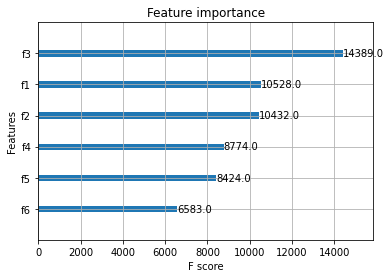

In [56]:
xgb.plot_importance(model)
plt.show()

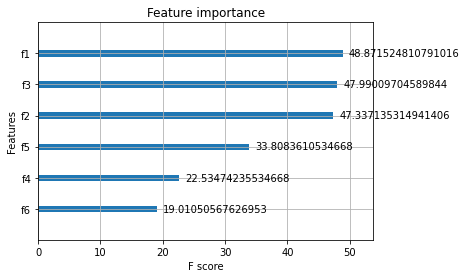

In [57]:
xgb.plot_importance(model,importance_type='gain')
plt.show()